In [182]:
import sys
import os

# modify syspath directory to sys.path

package_path = os.path.abspath(os.path.join('..','core'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..','utils'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..'))
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt

from IPython.display import HTML # both needed to disply gifs
from PIL import Image

# Import modules from the package
from core import create_hamiltonian as ch
from core import create_state as cs
from core import create_coherent_state
from core import time_evo
from core import time_evo_new
from core import time_evo_from_state
from core import time_evo_rd_ACL
from core import load_param
from core import load_H_list
from core import load_result
from core import load_tlist
from core import operators
from core.schmidt_solve import compute_schmidt_states_all_time
from core.eigen_ener_states import eigen_ener_states as eig
from core import annihilation_operator
from utils.entropy import compute_VN, plot_VN, compute_VN_time, plot_VN_numpy
from utils import collapse_gif
from utils.collapse_gif import collapse_gif
from utils.display_gif import display_gif
from utils.distribution_gif import gif_distribution_eig_total
from utils.distribution_gif import prob_gif
from utils.distribution_gif import gif_distrib_H_s_int
from utils.distribution_gif import gif_distrib_system_first_eig
from utils.plot import plot_basic
from utils.plot import plot_with_binning
from utils.basic_functions import state_distribution_eig_tot
from utils.basic_functions import random_dephasing
from utils.basic_functions import get_state_probabilities
from utils.basic_functions import position
from utils.basic_functions import copy_cat
from utils.basic_functions import plot_einselection
from utils.overlap import overlap
from utils.overlap import gif_schmidt_overlap
from utils.interference import interference_plot
from utils.expectations import exp_val_time
from utils.plot_hamiltonians import plot_hamiltonians

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.titlesize'] = 16             # Title font size
plt.rcParams['axes.titleweight'] = 'bold'       # Title font weight
plt.rcParams['axes.labelsize'] = 14             # X and Y label font size
plt.rcParams['axes.labelweight'] = 'bold'       # X and Y label font weight
#plt.rcParams['axes.grid'] = True                # Enable grid
#plt.rcParams['grid.alpha'] = 0.7                # Grid transparency
#plt.rcParams['grid.linestyle'] = '--'           # Grid line style
#plt.rcParams['grid.color'] = 'gray'             # Grid color

# Tick settings
plt.rcParams['xtick.labelsize'] = 12            # X tick label size
plt.rcParams['ytick.labelsize'] = 12            # Y tick label size
plt.rcParams['xtick.direction'] = 'in'          # X tick direction
plt.rcParams['ytick.direction'] = 'in'          # Y tick direction
plt.rcParams['xtick.major.size'] = 6            # X major tick size
plt.rcParams['ytick.major.size'] = 6            # Y major tick size

# Legend settings
plt.rcParams['legend.fontsize'] = 12            # Legend font size
plt.rcParams['legend.frameon'] = True           # Enable legend frame
plt.rcParams['legend.framealpha'] = 0.9         # Legend frame transparency
plt.rcParams['legend.loc'] = 'best'             # Legend location

# Line and marker settings
plt.rcParams['lines.linewidth'] = 2             # Line width
plt.rcParams['lines.markersize'] = 6            # Marker size

custom_colors = ['#1c4587', '#e6194B', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

Decoherence and 2 locality:

Here we look at the effect of the environment Hamiltonian being 2-local on decoherence. We know that decoherence happens very well with 2-local Hamiltonians as we see its effects in the classical world around us and every time we work with quantum systems. The question is then not "are 2-local Hamiltonians capable of decoherence., nor is it "Can we achieve deocherence without 2-locality" as a fully random matriux is more scrambling than a 2-local one. The question is "What does the constraint of 2-locality do to the deocherence we deal with everyday?"

As a bonus we can also look at the impact of geometric locality on decoherence. ie, make the spin chain a chain and only the nearest qubit interact with it and then the qubits themselfs only interact with nn.

potential result: the environment interactions are 2-local only wrt a basis. does that mean we should expect something? ie, deochernece speed shouldn't depend on the basis in which we are looking at thing? Or rather, somehow decoherence and the einselected pointer basis is more readily a basis in which the environment looks 2-local?

What needs to be done: Define the time evol and Hamiltonian creation functions that are 2-local.

Do simulations:

Define appropriate decoherence quantities to look at.

Make some pretty graphs.

Initial choices: Work with simplest possible Hamiltonian


We create the simplest decoherence model, so a simple HsxHe...

H=h1x(sum_ihisixsi)

need to show it but i think that I can make a complet basis of hermitian operators in 2qubit space with XX,XZ,YY,ZX,ZZ. not i didn't include the opposities, ie XZ but not ZX



<h1>Generate Hamiltonian

In [183]:
ar=np.array
kr=np.kron
idn=np.identity
sx=ar([[0,1],[1,0]])
sy=ar([[0,-1j],[1j,0]])
sz=ar([[1,0],[0,-1]])
id2=ar([[1,0],[0,1]])

n=6

H = np.zeros((2**n, 2**n), dtype=np.complex64)

for i in range(n):
    for j in range(n):
        if j>i:
            s1=kr(kr(idn(2**i),sx),idn(2**(n-i-1)))
            s2=kr(kr(idn(2**j),sx),idn(2**(n-j-1)))
            H+=np.random.rand()*s1@s2
            s1=kr(kr(idn(2**i),sx),idn(2**(n-i-1)))
            s2=kr(kr(idn(2**j),sz),idn(2**(n-j-1)))
            H+=np.random.rand()*s1@s2
            s1=kr(kr(idn(2**i),sz),idn(2**(n-i-1)))
            s2=kr(kr(idn(2**j),sx),idn(2**(n-j-1)))
            H+=np.random.rand()*s1@s2
            s1=kr(kr(idn(2**i),sy),idn(2**(n-i-1)))
            s2=kr(kr(idn(2**j),sy),idn(2**(n-j-1)))
            H+=np.random.rand()*s1@s2
            s1=kr(kr(idn(2**i),sz),idn(2**(n-i-1)))
            s2=kr(kr(idn(2**j),sx),idn(2**(n-j-1)))
            H+=np.random.rand()*s1@s2
            s1=kr(kr(idn(2**i),sx),idn(2**(n-i-1)))
            s2=kr(kr(idn(2**j),sz),idn(2**(n-j-1)))
            H+=np.random.rand()*s1@s2
            s1=kr(kr(idn(2**i),sz),idn(2**(n-i-1)))
            s2=kr(kr(idn(2**j),sz),idn(2**(n-j-1)))
            H+=np.random.rand()*s1@s2

#plt.imshow(H, cmap='hot', interpolation='nearest')
#plt.colorbar()  # Adds a color bar to interpret the scale
#plt.title("Heat Map of Matrix H")
#plt.show()

<h1>Create a state

In [184]:
n_system_qubits = 1  # Number of qubits in the system
n_environment_qubits = n  # Number of qubits in the environment

# Create the superposition state for the system
system_superposition_state = (qt.basis(2, 0) + qt.basis(2, 1)).unit()
random_state = qt.rand_ket(2**n)
state = qt.tensor(system_superposition_state, random_state)
print(f"Dimension of the combined state: {state.dims}")

Dimension of the combined state: [[2, 64], [1, 1]]


<h1>Do time evolution

In [185]:
def time_evo(H_e,state,log=0,tmax=10,ind_nb=100,file_name="default"):
    sz=ar([[1,0],[0,-1]])
    H_e=qt.Qobj(H_e)
    H_s = qt.Qobj(sz)  # Identity for system
    # Total Hamiltonian: Tensor product of system identity and environment Hamiltonian
    H = qt.tensor(H_s, H_e)

    tlist = np.linspace(0, tmax, ind_nb) # Linear spacing
    if log == 0:
        tlist = np.linspace(0, tmax, ind_nb)  # Linear spacing
    elif log == 1:
        tlist = np.logspace(np.log10(1), np.log10(tmax+1), ind_nb)-1  # Logarithmic spacing
    else:
        raise ValueError("Invalid value for 'log'. It should be either 0 or 1.")
    info_list=[tmax, ind_nb,log,tlist]
    
    # Perform time evolution of the combined system
    result = qt.mesolve(H, state, tlist, [], [])

    # Save outputs in a .txt file
    outputs_dir = "outputs/simulation_results"
    if not os.path.exists(outputs_dir):
        os.makedirs(outputs_dir)
    
    # Save parameters in a .txt file
    params_file_path = os.path.join(outputs_dir, "params_" + file_name)
    with open(params_file_path, "w") as f:
        tmax, ind_nb,log
        f.write(f"tmax === {tmax}\n")
        f.write(f"ind_nb === {ind_nb}\n")
        f.write(f"log === {log}\n")
    
    # Save parameters in a .txt file
    tlist_file_path = os.path.join(outputs_dir, "tlist_" + file_name)
    np.save(tlist_file_path, tlist)
    
    # Save result in a .txt file
    result_file_path = os.path.join(outputs_dir, "result_" + file_name)
    qt.qsave(result, result_file_path)
    
    # Save H_list in a .txt file
    
    H_path = os.path.join(outputs_dir, "H_list_" + file_name)
    qt.qsave(H, H_path)
    
    return result, tlist, H, state, info_list

In [186]:
result, tlist, H, state, info_list = time_evo(H,state,log=0,tmax=0.3,ind_nb=100,file_name="2_locality_first_attempt")


In [187]:
tmax, ind_nb, log = load_param(file_name)
info = list(load_param(file_name))
H=load_H_list(file_name)
result=load_result(file_name)
tlist=load_tlist(file_name)
eigenenergies,eigenstates =H.eigenstates()

In [188]:
def compute_schmidt_states_new(result, time_index,d1,d2):
    global_state = result.states[time_index]
    density_matrix = qt.ptrace(global_state, [0]) # Calculate the density matrix at the specified time
    eigenvalues, eigenstates = density_matrix.eigenstates() # Compute the eigenstates and eigenvalues of the density matrix
    eigenstates = [np.array(state.full()) for state in eigenstates]
    schmidt_states_s = []
    schmidt_states_e = []
    schmidt_values = []
    i=0
    for state_, eigenvalue in zip(eigenstates, eigenvalues):
        schmidt_values.append(eigenvalue)
        if eigenvalue < 10e-14:
            # If the eigenvalue is zero, set the Schmidt state to a zero vector
            schmidt_states_s.append(np.zeros_like(state_))
        else:
            #print(f"state {state}")
            i=i+1
            #N=qt.norm(state_)
            N=abs(np.vdot(state_,state_))
            schmidt_states_s.append(state_/np.sqrt(N)) # Normalize

    # Sort the Schmidt states by eigenvalue in descending order
    schmidt_states_s, schmidt_values = zip(*sorted(zip(schmidt_states_s, schmidt_values), key=lambda x: -x[1]))
    #d=np.size(global_state)
    #print(f"d {d}")
    #d1 = np.size(schmidt_states_s[0])
    #d2=d//d1
    #compute the schmidt states of the environement.
    schmidt_states_e = []
    I = np.eye(d2)
    #to get schmidt_env, we use that schmidt 1 and 2 of the system are |phi1> and |phi2>. 
    #Then we have that the global state can always be written as |psi>=s1|phi1>|a1>+s2|phi2>|a2>  
    for j in range(i):
        #step 1: get |phi_i>|ai>
        state = schmidt_states_s[j] #getting |phi_i>, is normalized
        P_a_state = np.kron(np.outer(state,state.conjugate().T),I) #def projector |phi_i><phi_i|xId, np.outer transposes the second one
       
        temp = np.dot(P_a_state,global_state) #We apply the projector on the global state: P|psi>=s1|phi_i>|a_i> and normalize. vdot is conjugate on first one. To normalize /schmidt_values[j] potentially
        temp = temp.flatten()
        #temp1=temp.full()
        #print(f"temp1 {temp1}")
        #step 2:We have |phi_i>|a_i>. We know |phi_i> and want |a_i>. |phi_i>|a_i> = (phi^1_i|a_i>,phi^2_i|a_i>, ...)
        #find the first nonzero coeff of |phi_i> and use it to extract |a_i>
        nonzero_index = np.nonzero(state)[0][0] #will need to know the index of a nonzero value in |phi_i>
        #now extract a d2 sized vector from thatd2*d1 sized vector
        temp2 = temp[nonzero_index*d2:(nonzero_index+1)*d2] #for k the nnzero index, this is phi^k_i|a_i>
        temp3=temp2/state[nonzero_index]
        N = abs(np.vdot(temp3[0].full(),temp3[0].full()))
        
        schmidt_states_e.append(temp3/np.sqrt(N))

    return schmidt_states_s,schmidt_states_e,schmidt_values

def compute_schmidt_full(result,idx,s=1):
    ss, se, sv = compute_schmidt_states_new(result, idx,d1,d2)
    if s==1:
        a = ss[0] #schmidt 1 on system 1
        a = np.squeeze(a)
        b = se[0] #schmidt 1 on system 2
        b=np.squeeze(b)
        g = np.outer(a,b).flatten()
        g=np.squeeze(g)
    elif s==2:
        a = ss[1] #schmidt 2 on system 1
        a = np.squeeze(a)
        b = se[1] #schmidt 2 on system 2
        b=np.squeeze(b)
        g = np.outer(a,b).flatten()
        g=np.squeeze(g)
    return g

def compute_schmidt_states_all_time(result, ind_nb,d1,d2):

    #TODO
    #-Another thing i want to do here is to outpute for all time the compute_schmidt_full() without redundancy in the computation
    #-Make it do both env and syst.
    schmidt_states_s_tlist=[]
    schmidt_states_e_tlist=[]
    schmidt_values_tlist=[]
    schmidt_full_tlist=[]
    

    for time_index in range(ind_nb):
        ss, se, sv = compute_schmidt_states_new(result, time_index,d1,d2)
        
        schmidt_states_s_tlist.append(np.squeeze(ss))
        schmidt_states_e_tlist.append(se)
        schmidt_values_tlist.append(sv)

        #making the full schmdits #TODO this will have to be modified to make it work for more than 2 superpositions
        a1 = ss[0].flatten() #schmidt 1 on system 1
        a1 = np.squeeze(a1)
        b1 = se[0].flatten() #schmidt 1 on system 2
        b1 = np.squeeze(b1)
        g1 = np.outer(a1,b1).flatten()
        g1 = np.squeeze(g1)
        a2 = ss[1].flatten() #schmidt 2 on system 1
        a2 = np.squeeze(a2)
        if time_index != 0:
            b2 = se[1].flatten() #schmidt 2 on system 2
            b2=np.squeeze(b2)
        else:
            b2 = np.zeros_like(b1)
        g2 = np.outer(a2,b2).flatten()
        g2=np.squeeze(g2)
        g=[g1,g2]
        schmidt_full_tlist.append(g)

    return schmidt_states_s_tlist,schmidt_states_e_tlist,schmidt_values_tlist,schmidt_full_tlist

In [189]:
s_list = compute_schmidt_states_all_time(result, ind_nb,2,2**n)
ss_list = s_list[0]
se_list= s_list[1]
sv_list = s_list[2]
s_full_list=s_list[3]

<h1>Now we look at the result to see decoherence

Sadly the collapse gif wont be visible since I am only working with a qubit
But I can still see the Schmidt states probabilities change I think. and I can still see the Schmidt states converge towards the pointer states.


In [190]:
def plot_VN_numpy(d1,d2,result,tlist,log=0):
    # Store results
    density_matrices = []
    entropies = []
    for state in result.states:
        
        # Calculate the density matrix from the pure state
        rho = qt.ket2dm(state)  # This converts the pure state into a density matrix
        density_matrix_qobj = qt.Qobj(rho, dims=[[d1, d2], [d1, d2]])
        traced_system = qt.ptrace(density_matrix_qobj, 1)  # Keep qubits 2 and 3
        entropy=qt.entropy_vn(traced_system)
        entropies.append(entropy)

    # Plot entropy over time
    plt.plot(tlist, entropies, label="Subsystem Entropy")
    plt.xlabel('Time')
    plt.ylabel('Von Neumann Entropy')
    plt.title('Subsystem Entropy Over Time')
    if log == 1:
        plt.xscale('log')
    else:
        plt.xscale('linear')
    plt.grid(True)
    plt.legend()
    plt.show()
    return entropies

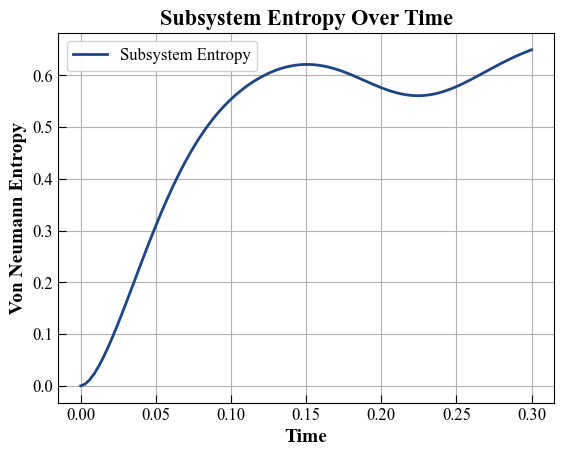

[3.2225233102816276e-15,
 0.0035355966631091832,
 0.011900672559090622,
 0.023792920055945473,
 0.03848361189588409,
 0.055436762527979716,
 0.07421795451758204,
 0.0944571557598894,
 0.1158302736221182,
 0.13804897070736333,
 0.1608546325818351,
 0.18401461081820053,
 0.2073198126223199,
 0.2305830450532759,
 0.253637860188845,
 0.276337641442832,
 0.29855482462858335,
 0.32018021615363756,
 0.34112222551444227,
 0.3613061580103169,
 0.3806733273539392,
 0.399180174708614,
 0.41679717902996066,
 0.4335077652570126,
 0.44930708755693993,
 0.46420071764512605,
 0.4782032850545696,
 0.49133700574654765,
 0.5036302688747394,
 0.5151161221546287,
 0.5258308663701172,
 0.5358126390660514,
 0.5451001014640096,
 0.5537311995598643,
 0.5617420796433152,
 0.5691661715040923,
 0.5760334312740948,
 0.582369766506904,
 0.588196661038908,
 0.5935310123733051,
 0.5983851798384299,
 0.6027672114440068,
 0.6066812521306806,
 0.6101281042565102,
 0.6131059320429494,
 0.6156110846115126,
 0.617638983595

In [191]:
plot_VN_numpy(2,2**n,result,tlist,log=0)

In [192]:
def collapse_gif(ind_nb,H_s, s_list):

    # Compute global min and max values for Schmidt coefficients to fix y-axis limits
    if env_sys == 0:
        #eigenenergies_system_1 = eig[0]
        #eigenstates_system_1 = eig[3]
        eigenenergies,eigenstates = H_s.eigenstates()
        
        all_schmidt_coefficients = []
        for frame in range(ind_nb):
            s0 = s_list[0][frame][0]
            schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates]
            all_schmidt_coefficients.extend(schmidt_coefficients0)

        min_schmidt = min(all_schmidt_coefficients)
        max_schmidt = max(all_schmidt_coefficients)

    else:
        eigenenergies = eig[14]
        eigenstates = eig[15]
        all_schmidt_coefficients = []
        for frame in range(ind_nb):
            s0 = s_list[0][frame][0]
            schmidt_coefficients0 = [abs(np.vdot(s0, eigenstate)) ** 2 for eigenstate in eigenstates]
            all_schmidt_coefficients.extend(schmidt_coefficients0)

        min_schmidt = min(all_schmidt_coefficients)
        max_schmidt = max(all_schmidt_coefficients)

    # Create a figure
    fig = plt.figure(figsize=(10, 5))

    # Create the animation
    ani = FuncAnimation(fig, update_collapse, fargs=(eigenenergies, eigenstates, s_list, min_schmidt, max_schmidt), frames=ind_nb, interval=100)

    # Save the animation as a GIF
    path = f'../outputs/gifs/collapse_param_{info_list[0]}_{info_list[1]}_{info_list[2]}_{info_list[3]}_{info_list[4]}_{info_list[5]}_{info_list[6]}_{info_list[7]}_{info_list[8]}.gif'
    ani.save(path, writer='pillow')
    plt.close()

In [193]:
gif_path = collapse_gif(eigen, s_list, info)
display_gif(gif_path)
plot_VN(result,tlist)

NameError: name 'eigen' is not defined